In [1]:
## Import Libraries
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import openpyxl

pd.set_option("max_colwidth", None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
'''
function name: parse_df_columns

purpose: parsing the last aggregate column of the gtf/gff3 into useful columns and cleaning non-relevant columns

input: dataframe containining "raw" gtf/gff

output: dataframe containing gtf with useful columns ["gene_id", "transcript_id", etc...]
'''

def parse_df_columns(df, is_ref=True):

    if is_ref:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split("source_gene=", expand=True)[1].str.split(';', expand=True)[0]
        
        ## Get gene names
        df["gene_name"] = df["other"].str.split("source_gene_common_name=", expand=True)[1].str.split(';', expand=True)[0]
        
        ## Only keep relevant
        df = df[["chr", "gene_id", "gene_name"]].copy()

        ## Drop duplicates
        df.drop_duplicates(inplace=True)
        

    else:

        ## Get CHM gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)

        ## Drop "other" column
        df = df[["chr", "gene_id"]].copy()
        
    for col in df.columns:
        df.loc[df[col].isnull(), col] = np.NaN
        

    return df

In [3]:
'''
function name: calculate_cpm

purpose: Calculate CPM for the each sample given

input: Counts dataset

output: Counts dataset with CPM columns as well
'''

def calculate_cpm(df):

    ## Loop through counts columns to calculate CPM and add to the dataframe
    for col in ["total_counts"]:
        
        df[col] = round(df[col], 2)
        cpm_name = col.replace("_counts", "_CPM")
        df[cpm_name] = round(((df[col]/(df[col].sum())) * 1000000), 2)
    
    return df 

In [4]:
## Import transcripts
df_transcripts = pd.read_csv("../../data/raw/merged_uky_cshl_CHM13_discovery/bambu_discovery/counts_transcript.txt",
        sep="\t", low_memory=False, header=0)

In [5]:
## Import Genes
df_genes = pd.read_csv("../../data/raw/merged_uky_cshl_CHM13_discovery/bambu_discovery/counts_gene.txt",
        sep="\t", low_memory=False, header=0)

In [6]:
## Get total counts for genes and transcripts
df_genes["total_counts"] = df_genes[df_genes.columns[1:]].sum(axis=1)
df_transcripts["total_counts"] = df_transcripts[df_transcripts.columns[2:]].sum(axis=1)

In [7]:
## Get average counts for genes and transcripts
df_genes["average_counts"] = df_genes["total_counts"]/4
df_transcripts["average_counts"] = df_transcripts["total_counts"]/4

In [8]:
## Only keep genes and transcripts with more than 0 counts
df_genes = df_genes.loc[df_genes["total_counts"] > 0].copy()
df_transcripts = df_transcripts.loc[df_transcripts["total_counts"] > 0].copy()

In [9]:
## Calculate percentile
df_genes['percentile'] = df_genes["total_counts"].rank(pct=True)

In [10]:
## Calculate Rank
df_genes['rank'] = df_genes["total_counts"].rank(ascending=False)

In [16]:
## See rank for SNAP25
df_genes.loc[df_genes.index.str.contains("ENSG00000132639")]

,cshl_356_uky_mapped_filtered_sorted,cshl_1304_uky_mapped_filtered_sorted,cshl_1271_uky_mapped_filtered_sorted,cshl_1291_uky_mapped_filtered_sorted,total_counts,percentile,rank
ENSG00000132639.13,96275.0,157565.0,289730,75717.0,523012.0,0.99938,33.0


In [17]:
## Get total counts for all genes with more than 0 counts
total_counts = df_genes["total_counts"]

In [18]:
## Get log total counts
log_total_counts = np.log10(df_genes["total_counts"])

In [19]:
## Use ggplot colors
ggplot2_colors = ["#F8766D", "#CD9600", "#7CAE00", "#00BE67", "#00BFC4", "#00A9FF", "#C77CFF", "#FF61CC"]

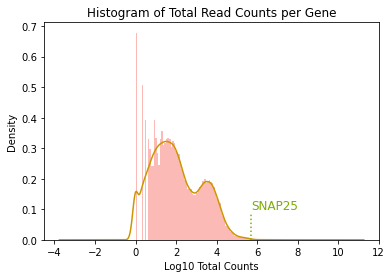

In [20]:
## Create log plot

fig, ax = plt.subplots(figsize = (6,4))


log_total_counts.plot(kind = "hist", density = True, bins = 100, color="#F8766D", alpha=0.5) # change density to true, because KDE uses density


log_total_counts.plot(kind = "kde", color="#CD9600", alpha=1)

ax.set_xlabel("Log10 Total Counts")


ax.set_title("Histogram of Total Read Counts per Gene")

ax.axvline(5.71, alpha=1, ymax = 0.12, linestyle = ":", color="#7CAE00")


ax.text(5.71, 0.10, "SNAP25", size = 12, alpha = 1, color="#7CAE00")


plt.show()

In [22]:
## Import extended annotation
gtf = pd.read_csv("../../data/raw/merged_uky_cshl_CHM13_discovery/bambu_discovery/extended_annotations.gtf",
        sep="\t", names=["chr", "source", "type", "start", 
                               "end", "dot_1", "strand", "dot_2", "other"], low_memory=False, header=0)

In [23]:
## Parse through it
gtf = parse_df_columns(gtf, is_ref=False)

In [24]:
## Get gene ids for mitochondrial genes
gtf_mito_ids = gtf.loc[gtf["chr"] == "chrM"]["gene_id"]

In [26]:
## Select only nuclear genes
df_genes_nuclear = df_genes.loc[~df_genes.index.isin(gtf_mito_ids)]

In [27]:
## Total counts for nuclear genes
total_counts_nuclear = df_genes_nuclear["total_counts"]

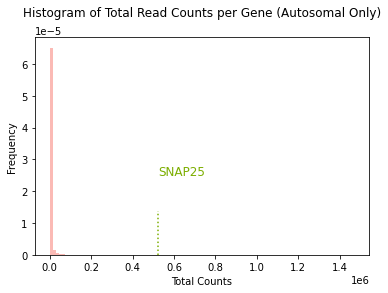

In [29]:
## Make graph for nuclear genes
fig, ax = plt.subplots(figsize = (6,4))

total_counts_nuclear.plot(kind = "hist", density = True, bins = 100, color="#F8766D", alpha=0.5) # change density to true, because KDE uses density

ax.set_xlabel("Total Counts")

ax.set_title("Histogram of Total Read Counts per Gene (Nuclear Only)\n")

ax.axvline(523012.0, alpha=1, ymax = 0.2, linestyle = ":", color="#7CAE00")

ax.text(523012.0, 0.000025, "SNAP25", fontsize = 12, alpha = 1, color="#7CAE00")


plt.show()

#####################################################################################################

In [17]:
df_transcripts = df_transcripts[['TXNAME', 'GENEID', 'total_counts', "average_counts",
                                 'cshl_356_uky_mapped_filtered_sorted',
                                   'cshl_1304_uky_mapped_filtered_sorted',
                                   'cshl_1271_uky_mapped_filtered_sorted',
                                   'cshl_1291_uky_mapped_filtered_sorted']]

In [18]:
df_transcripts.columns = ['t_id', 'g_id', 'total_counts', 'avg_counts', '356_counts',
       '1304_counts',
       '1271_counts',
       '1291_counts']

In [20]:
## Look at SNAP25 expression
df_transcripts.loc[df_transcripts["g_id"].str.contains("ENSG00000132639")]

,t_id,g_id,total_counts,avg_counts,356_counts,1304_counts,1271_counts,1291_counts
6028,ENST00000254976.7,ENSG00000132639.13,452745.057677,113186.264419,73226.941808,120755.178982,243469.016722,15293.920165
11458,ENST00000304886.6,ENSG00000132639.13,73336.246871,18334.061718,8086.473459,21690.564855,40238.846864,3320.361692
54495,ENST00000430336.1,ENSG00000132639.13,488.710918,122.177730,69.084351,122.176656,213.103812,84.346099
99540,ENST00000492814.1,ENSG00000132639.13,26.000324,6.500081,0.000000,20.000324,0.000000,6.000000
102012,ENST00000495883.1,ENSG00000132639.13,92690.984209,23172.746052,14892.500381,14977.079182,5809.032602,57012.372044
